# Implementation and evaluation of K-nearest neighbors (KNN) algorithm for handwritten digit recognition.
### Nina Gutzeit, Maximimilian Hingerl, Emma Kray, Johannes Müller
### July 2021

## Introduction
(...)

In [6]:
# imports
%load_ext autoreload
%autoreload 2
from functions.Load_data import load_the_pickle
import numpy as np
train_labels, train_values = load_the_pickle('data/train_points.p')
train_data = np.column_stack([train_labels, train_values])
test_labels, test_values = load_the_pickle('data/test_points.p')
test_data = np.column_stack([test_labels, test_values])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The data set
The data set consists of a training set of 60000 images and a test test with 10000 images. Each image is 28*28 pixels in size and the handwritten digits have been cropped to the center of the image. The data format is a csv file in which each row has the intensity values of the pixels of one image. The first column has the digit labels.

Below is a random sample of 25 images:

<Figure size 720x720 with 0 Axes>

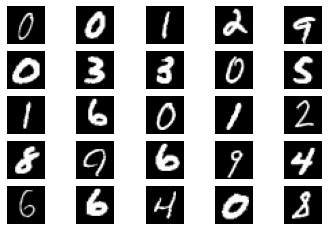

In [21]:
from functions.visualize_stan import sample_digits
# loading a selection of images
sample_digits()

## Data cleaning
The first step when dealing with such a data set is to check for errors or irregularities. Unexpected values such as NA values or outliers with intensity values outside of the range(0, 256) need to be dealt with. Possible solutions are removing the affected images or imputation of the individual values.


In [7]:
from functions.Data_cleaning import any_na
# Checking Training data for missing values:
any_na(train_data)
# Checking Test data for missing values:
any_na(test_data)

There are no missing values in this data.
There are no missing values in this data.


In [11]:
from functions.Data_cleaning import rm_range
# Checking data for range
rm_range(train_values)
rm_range(train_labels, upper=10)
rm_range(test_values)
rm_range(test_labels, upper=10)

No values out of range.
No values out of range.
No values out of range.
No values out of range.


There are no irregularities of these kinds in the data set.

Other types of unusual data could include duplicate images. This can interfere with the knn algorithm and therefore need to be removed:

In [9]:
from functions.Data_cleaning import rm_duplicates
rm_duplicates(train_data)
rm_duplicates(test_data)

No Duplicates.
No Duplicates.


Again there are no duplicate errors. The data is cleaned, however errors such as incorrect image labelling and image orientation are not accounted for.

## Standardization and PCA preparation
The images have different brightnesses and therefore need to be standardized. The intensity mean is calculated over every image and subtracted from each pixel. These values are divided by the standard deviation. The resulting images are standardized.

The data needs to be prepared for PCA by standardizing it across all images. This is done because it is important that all pixels have the same magnitude/ weight. This is especially important for data with variables that have different units. Here differences in variance can occur between different pixel positions. For example one pixel position could have intensities between 0 and 9 whilst another pixel has values between 100 and 150. This can cause the PCA to 'unjustly' assign more importance to the larger variance. The second pixel will dominate the principle components even if the variance of the first pixel is just as defining.

Here two different operations were performed to prepare the data. The data was centered in a covariance operation or it was Z-transformed in calculating the correlation matrix.

Covariance is calculated by:     
$$\text{cov}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \left(X_i - \overline{X}\right)\left(Y_i - \overline{Y}\right)$$   

where X and Y are columns of a given matrix, N is the number of columns and cov(x,y) is the resulting entry of the covariance matrix.

The covariance operation includes centering: $ (X_i - \overline{X}) $, where the mean of X is subtracted from each value in the column. The same is true for Z transformation and correlation:

$$ \dfrac{(X_i - \overline{X})} {\sigma _ {i}} , \text{corr}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \dfrac {\left(X_i - \overline{X}\right)}{\sigma_{x}}\dfrac{\left(Y_i - \overline{Y}\right)}{\sigma_{y}} $$


where ${\sigma_{x}}$ is the standard deviation of the column X. In the dataset a column represents the intensity values of all images at a specific pixel position.

The mean and standard deviation of the training data set are used to prepare the images of digits to be predicted. This is because: (...). One matrix is standardized using the mean and standard deviation of the other matrix containing the training data.

Pixel positions in the training data set where every image has the same intensity value give a standard deviation of 0. Mathematically this leads to undefined values in the correlation matrix which the program returns as 'Nan'. Running the final algorithm over this data with the Nan values leads to a very poor result of less than 10% correct digit predicitions.

However, these variables include no information that distinguishes a "1" from a "2" because the values are the same accross all digits. Therefore instead of replacing 'Nan's with another value, these variables could be removed entirely. The same variables need to be removed in the test images.

### Comparing standardization methods
(vis stan doesn't work yet! Also missing comparison graphs for new standardization method)

In [23]:
#import vis_stan as vs

In [24]:
# Centered data performance on final algorithm:
#print('Correctly predicted digits: ', vs.hit_centered)
#print('Incorrectly predicted digits: ', vs.miss_centered)

In [25]:
# Z-transformed data performance:
#print('Correctly predicted digits: ', vs.hit_z)
#print('Incorrectly predicted digits: ', vs.miss_z)

(statistical test?)

Their performance is very similar, however the program is slightly more accurate when the data is only centered. To compare the 'quality' of the performances, here is a comparison of which digits are incorrectly identified:

In [26]:
# Centered missed digits vs Z transformed missed digits
#fig = plt.figure(figsize=(10, 10))
#plt.hist(vs.false_assignments_centered, bins= range(0,10))
#fig.ubplot(1,2,1)
#plt.hist(vs.false_assignments_z_transformed, bins= range(0,10))
#fig.subplot(1,2,2)

(stat test)

The distribution of falsely assigned digits is not noticeably different between the two methods. The plots reveal an interesting trend that some digits are more frequently mis-assigned than others.
Because the centered data performs better and does not require the removal of undefined values, it is selected as the default for the program.

## Principal Component Analysis

After the dataset was split and standardized, Principal Component Analysis (PCA) was applied. PCA is used to reduce the dimensionality of a data set while increasing its interpretability. The variables with the most directional variance are used to minimize the loss of information. The new uncorrelated variables, principal components, are calculated using eigenvalues/eigenvectors, where the eigenvectors are the principal components.

Eigenvectors are a set of vectors associated with a linear system of equations, such as a matrix. The idea behind an eigenvector is that given any matrix there is a set of n vectors $v_i$, that when multiplied with A results in a parallel/antiparallel vector to $v_i$. The resulting vectors length is then multiplied with the eigenvalue, which is some constant value. The mathematical definition of an eigenvector $v_i$ can be explained with the following equation:

$Av_i=λ_i v_i$

where A is the matrix and λ is the eigenvalue.

To calculate the eigenvector, first the eigenvalues need to be calculated. The formula

$det⁡(A-λI)=0$

can be used to calculate the eigenvalues. The determinant (det) of the difference between A and λ times I, the identity matrix, can be used to calculate the eigenvalues. The identity matrix consist of ones along the diagonal and zeros everywhere else. The solutions of λ are the corresponding eigenvalues for the matrix.

The last step is then calculating the eigenvectors using the eigenvalues. The formula

$Av_i=λ_i v_i$

is rearranged t

$(A-λ_i)\cdot v_i=0$

which, for example, for 2x2 matrix would looks like this:

\begin{pmatrix}
A-λ_i & A-λ_i\\
A-λ_i & A-λ_i
\end{pmatrix}
\begin{pmatrix}
v_{i,j}\\
v_{i,j}
\end{pmatrix}
= 0


From the resulting polynomial one can determine the eigenvector specific to the eigenvalue. The above calculation must be completed for every eigenvalue λ.

The variables `eigen_values, eigen_vectors` consist of the calculated eigenvalues and -vectors for the standardized train data set.

The eigenvectors are ranked based on their influence on the covariance of the data set. The eigenvectors with less significant directional variance are removed. This reduces the overall dimensionality.
```python
sorted_eigenvectors = eigen_vectors[:, sorted_index]
```
The above function sorts all eigenvectors based on greatest impact on variance.

The sorted eigenvectors are then reduced to the optimal number of components. The optimal number of components has the highest accuracy.

The function
```python
eigenvector_subset = sorted_eigenvectors[:, 0:num_components]
```
reduces the number of eigenvectors to the optimal number of principal components.
The attribute `train_evs` usually set to `train_evs=NONE`, which will be used during the iterations of the train set. When calling `PCA_func` on the test set, this attribute is set to `train_evs=train_evs`.
This then fullfiles the `if train_evs is not None` clause. The clause states:

```python
    if train_evs is not None:
        eigenvector_subset = train_evs
    X_reduced = np.dot(X_mean, eigenvector_subset)
    return X_reduced, eigenvector_subset
```

This code segment reduces the number of principal components of each test point to the before calculated subset of the training points.
At the end a matrix reduced to the number of principal components and the eigenvector subset are returned for further analysis.

The below 2D figures visualize the PCA for the test and train data sets. The colors correspond with a numerical digit. It is apperant from the graphs, that both the train and test data sets are similar as the color dispersal is similar.
The 3D graph is useful to understand how the PCA reduces the dimensionality of the data set. The actual dimensionality of the data set is much higher.

In [27]:
#import vis_pca as visp
#visp.components_test3.show()
#visp.components_test.show()
#visp.components_train.show()

## The knn algorithm

In [28]:
import functions.KNN_predict as knn
from functions.Load_data import load_the_pickle
from functions.PCA import PCA_func

from functions.Standardize import center
import itertools as itertools
import multiprocessing
from scipy.spatial import KDTree

k = 7
n_pca = 55
train_labels, train_values = load_the_pickle('data/train_points.p')
test_labels, test_values = load_the_pickle('data/test_points.p')


# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = PCA_func(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, Y=train_values)
test_values_pca, _ = PCA_func(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

### distance methods
The knn algorithm classifies the test-dataset based on the distances between a single test-datapoint and all points of the training dataset. These distances are then being sorted by
size and the k smallest distances were selected. By looking at the labels of these k nearest neighbours, the algorithm decides based on the major vote which label fits best for the tested data point.
There are many different ways to calculate distances, two methods were tested: The euclidean and the manhattan distance. The result of the knn algorithm delivers with both distance methods very good results. There was no big time difference.

In [29]:
%%time

hit_euclidean = 0
miss_euclidean = 0
predicted_label = []
for i in range(10000):
    result = knn.knn("euclidean",train_values_pca,train_labels,test_values_pca[i],k)
    predicted_label.append(result)

for sample in range(10000):
    if predicted_label[sample] == test_labels[sample]:
        hit_euclidean += 1
    else:
        miss_euclidean += 1

Wall time: 4min 16s


In [30]:
%%time
hit_manhattan = 0
miss_manhattan = 0
predicted_label = []
for i in range(10000):
    result = knn.knn("manhattan",train_values_pca,train_labels,test_values_pca[i],k)
    predicted_label.append(result)

for sample in range(10000):
    if predicted_label[sample] == test_labels[sample]:
        hit_manhattan += 1
    else:
        miss_manhattan += 1
        

Wall time: 4min 3s


In [31]:
print("accuracy using euclidean distance",hit_euclidean, "vs", miss_euclidean)
print("accuracy using manhattan distance",hit_manhattan, "vs", miss_manhattan)

accuracy using euclidean distance 9765 vs 235
accuracy using manhattan distance 9729 vs 271


### ways of implementing knn

#### slow and simple --> introducing multiprocessing
The first version of the algorithm uses knn-method as a function which classifies one test data point at a time. The code needs to iterate 10000 times over that function which results in a run time of over 6 minutes.
To improve that, python multiprocessing was integrated into the functioning but slow algorithm. Instead of running one process that iterates 10000 times over the knn function,
the multiprocessing function gets a range of numbers with which it should run the function and than creates a "pool" of tasks and starts an individual python process for each task-batch. That means that based on the system which runs the code the function creates multiple processes at once and splits the workload onto all processing cores of the computer.
For example on a computer with 4 cores the code can run 4 processes at a time efficently, due to that optimization we could bring down our run time from about 6 minutes to 100 seconds.

In [32]:
%%time
hit_knn_multiprocessing = 0
miss_knn_multiprocessing = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        #result = p.starmap(knn.knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        result = p.starmap(knn.weighted_knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_multiprocessing += 1
            else:
                miss_knn_multiprocessing +=1
        print("result using multiprocessing",hit_knn_multiprocessing, "vs", miss_knn_multiprocessing)

result using multiprocessing 9765 vs 235
Wall time: 2min 6s


#### quick and complicated
kd-trees

In [33]:
%%time
tree = KDTree(train_values_pca)

hit_knn_kdtree = 0
miss_knn_kdtree = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_kdtree += 1
            else:
                miss_knn_kdtree +=1
        print("result using a kdtree",hit_knn_kdtree, "vs", miss_knn_kdtree)

result using a kdtree 9765 vs 235
Wall time: 24.2 s



### optimal number of k and pcs
normal mnist --> k= 7 number of pcs = 55 hits=9765
mnist with weighted knn --> k= 4 number of pcs = 51 hits=9777
fashion mnist--> k=8  number of pcs = 77 hits=8679

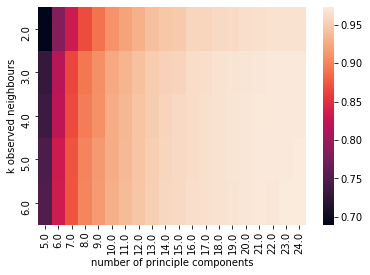

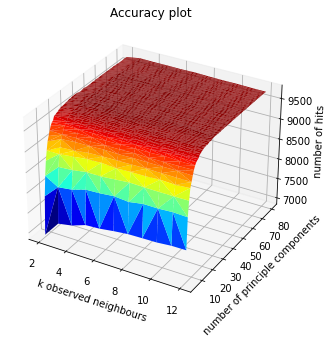

In [34]:
import functions.visualize_knn as vis_knn
#normal-mnist:
vis_knn.knn_heatmap("data/visualize_knn_mnist.npy",dropped_rows=([7, 8, 9, 10, 11, 12]),dropped_columns = ([25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]))
vis_knn.knn_3dplot("data/visualize_knn_mnist.npy")


# Additonal tested stuff

## Weighted knn

In [35]:
%%time
k = 4
n_pca = 51
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = PCA_func(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, Y=train_values)
test_values_pca, _ = PCA_func(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

hit_weightedknn = 0
miss_weightedknn = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.weighted_knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_weightedknn += 1
            else:
                miss_weightedknn +=1
        print("result using multiprocessing",hit_weightedknn, "vs", miss_knn_multiprocessing)
        print("result using normal knn",hit_knn_kdtree, "vs", miss_knn_kdtree)

result using multiprocessing 9777 vs 235
result using normal knn 9765 vs 235
Wall time: 2min 2s


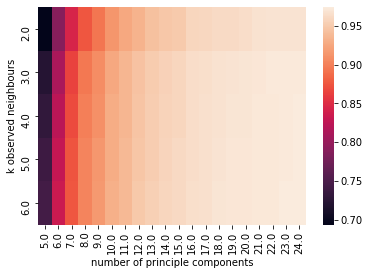

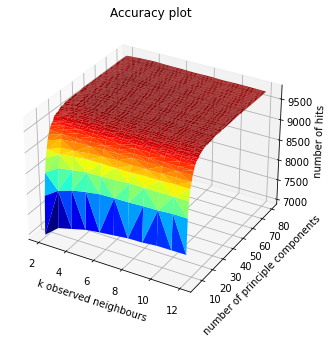

In [36]:
vis_knn.knn_heatmap("data/visualize_weighted_knn.npy",dropped_rows=([7, 8, 9, 10, 11, 12]),dropped_columns = ([25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]))
vis_knn.knn_3dplot("data/visualize_weighted_knn.npy")

## Comparison fashion mnist

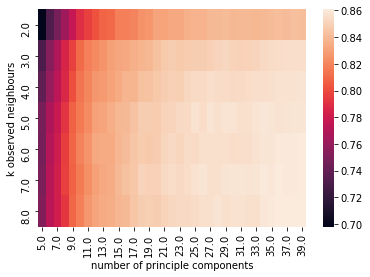

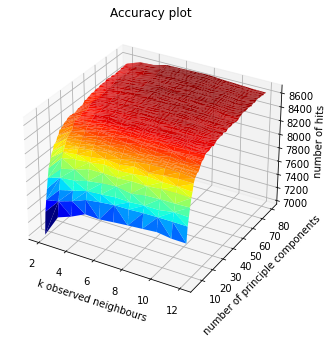

In [37]:
vis_knn.knn_heatmap("data/visualize_fashionmnist.npy",dropped_rows=([9, 10, 11, 12]),dropped_columns = ([40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]))
vis_knn.knn_3dplot("data/visualize_fashionmnist.npy")

## Phone numbers
One possible application of handwritten digit recognition is digitalising written information from documents like patient hospital forms, bank transfers or corona contact forms. This can speed up bureaucracy because an algorithm can work much faster than an employee manually typing the information into a computer.
Shown here is how the telephone number section of a form could work.
The form needs to have a section that the computer can read, the rest of the information is cropped. For phone numbers each box is a space in which a person can write one digit of their number.

The form is scanned in or the writing is done with a digital pen or a mouse. Then the image is cropped. Each digit is converted to a 28*28 pixel greyscale image, which is then inverted and flattened. The resulting array can be fed to the algorithm.

In [13]:
from functions.Phone_numbers import form_filled_in
from functions.Phone_numbers import call_me_maybe
from functions.Phone_numbers import show_phone_numbers

Here is an example phone number. The program correctly identifies all the digits:

In [20]:
digits = form_filled_in("digits/Phone number form example.png")
phone_number = call_me_maybe(digits)
print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

Your phone number is:
012345678990

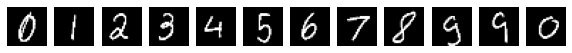

In [40]:
show_phone_numbers("digits/Phone number form example.png")

However, this is not always the case. Below is an example where the algorithm incorrectly predicts 11 out of 12 digits:

In [21]:
digits = form_filled_in("digits/Phone number form example 2.png")
phone_number = call_me_maybe(digits)

print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

Your phone number is:
262558243236

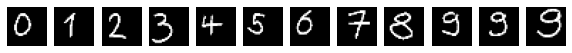

In [42]:
# The correct phone number:
show_phone_numbers("digits/Phone number form example 2.png")

First observations suggest the correct prediction rate is roughly at 8/12 digits correctly identified. For phone numbers this is a rather undesirable result, as a single error means that the number will not connect to the right person.
The accuracy seems to vary greatly between different handwriting. The examples above are written by two different people.
Interestingly the algorithm seems to be a lot better at predicting some numbers. 11/12 twos and fours are identified correctly, whereas barely 1/12 nines are recognized. This difficulty with 9s was noted before and is something worth looking into.

These numbers are based off of experimentation with our own handwriting and are therefore not representative.

There are a few reasons why the success of our digit recognition could be limited:
- digital writing tool rather than analogue like MNIST
- not optimally centered or cropped
- 60000 training digits is not enough
- "cultural" handwriting differences: crossing 7s, "capping" 1s

# Discussion

# References